In [79]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 12:00:00 -p gpu_quad --gres=gpu:rtx8000:1 ./01_cohort_to_cohort_transfer.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-compass/')
from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_embed_with_label, score2
from compass.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)
import warnings
warnings.filterwarnings("ignore")


In [80]:
cohort_name_map = {'Choueiri': 'Choueiri',
 'Miao': 'Miao',
 'Snyder': 'Snyder',
 'SU2CLC2': 'Ravi-2',
 'Zhao': 'Zhao',
 'Hugo': 'Hugo',
 'MGH': 'Freeman',
 'Allen': 'Allen',
 'Kim': 'Kim',
 'Riaz': 'Riaz',
 'Gide': 'Gide',
 'Rose': 'Rose',
 'SU2CLC1': 'Ravi-1',
 'Liu': 'Liu',
 'IMmotion150': 'IMmotion150',
 'IMVigor210': 'IMVigor210'}


In [81]:
data_path = '../../../paper/00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
df_label.cohort = df_label.cohort.map(cohort_name_map)

df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))

df_task = onehot(df_label.response_label)
size = df_label.groupby('cohort').size()
size = size.index + "\n(n=" + size.astype(str) + ")"


dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfy = df_task
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()

size.loc[cohorts]

cohort
Choueiri           Choueiri\n(n=16)
Miao                   Miao\n(n=17)
Snyder               Snyder\n(n=21)
Ravi-2               Ravi-2\n(n=25)
Zhao                   Zhao\n(n=25)
Hugo                   Hugo\n(n=26)
Freeman             Freeman\n(n=34)
Allen                 Allen\n(n=39)
Kim                     Kim\n(n=45)
Riaz                   Riaz\n(n=51)
Gide                   Gide\n(n=73)
Rose                   Rose\n(n=89)
Ravi-1              Ravi-1\n(n=102)
Liu                    Liu\n(n=107)
IMmotion150    IMmotion150\n(n=165)
IMVigor210      IMVigor210\n(n=298)
dtype: object

In [128]:
large_cohorts = [ 'Ravi-1',
 'Liu',
 'IMmotion150',
 'IMVigor210']

medium_cohorts = [ 'Freeman',
 'Allen',
 'Kim',
 'Riaz',
 'Gide',
 'Rose',]

In [129]:
s = df_label.groupby('cohort').size()
cohort_30 = s[s > 30].index.to_list()
len(cohort_30),len(cohorts)

(10, 16)

In [151]:
data = pd.read_csv('./results/c2c_raw_data.csv', index_col=0)
data = data[data.train_cohort.isin(cohorts) & data.test_cohort.isin(cohort_30)]
data.shape

(3900, 13)

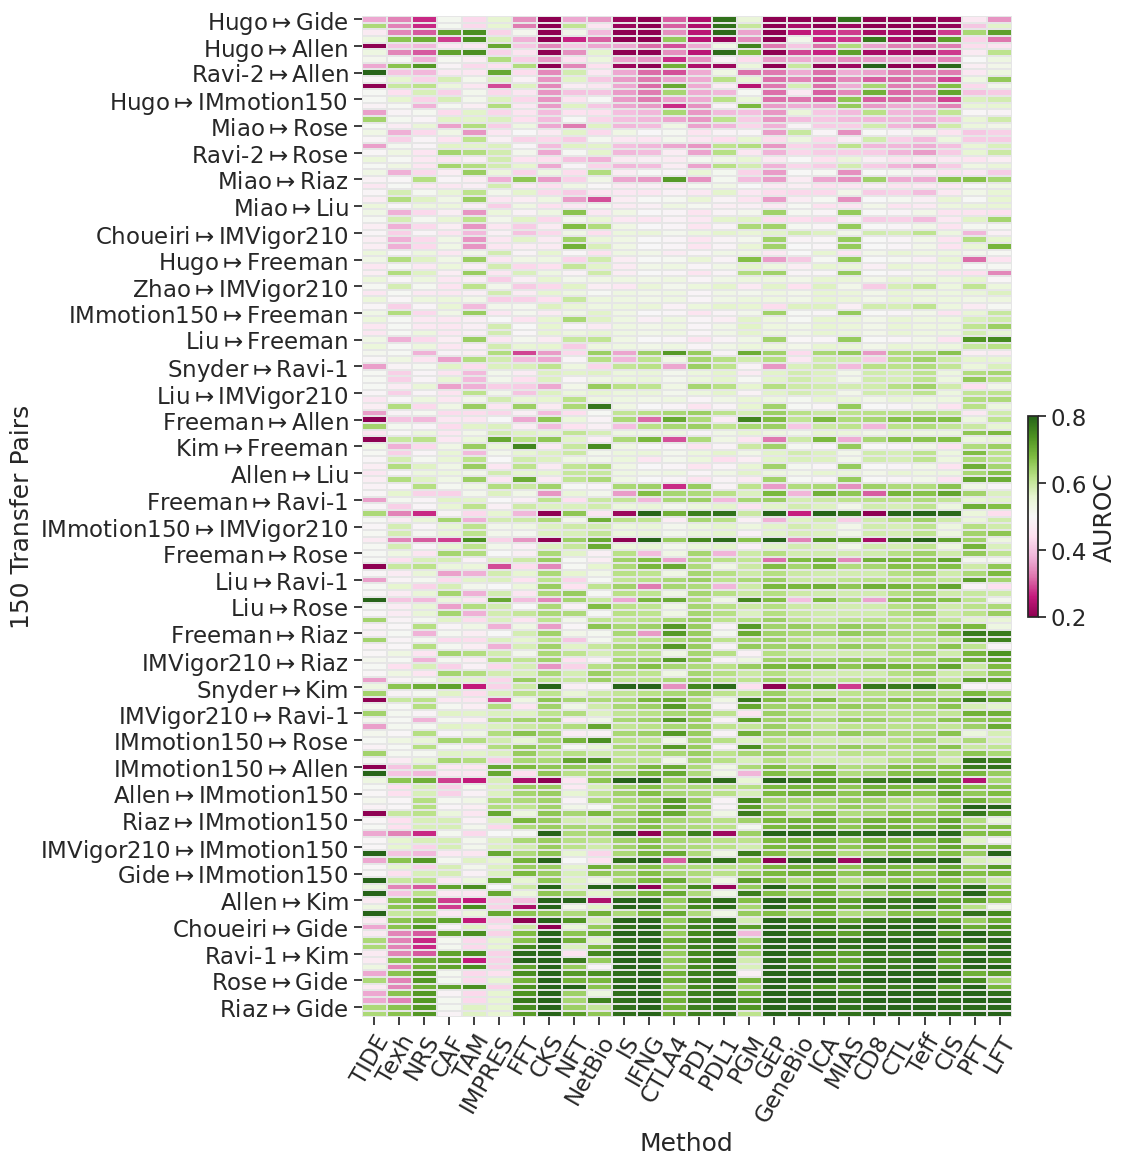

In [159]:
dfp = pd.pivot_table(data, columns = 'mode', index='transfer', values = 'ROC' )

dfp.to_csv('./results/c2c_roc_raw.csv')

x_order = dfp.mean().sort_values().index.tolist()
y_order = dfp.mean(axis=1).sort_values().index.tolist()

dfp = dfp[x_order].loc[y_order]

fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(dfp, annot=False,
        cmap = 'PiYG', ax = ax, vmax = 0.8, vmin=0.2,
        cbar = False,
            
        # cbar_kws = dict(use_gridspec=True,
        #                 shrink=0.2, 
        #                 label = 'AUROC', 
        #                 location="right"), 
            
        linewidths=0.005, linecolor = '0.9')#


ax.tick_params(axis='both', which='major', right = False,
               top=False, direction = 'out',reset = True)
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke
ax.set_ylabel('150 Transfer Pairs')
ax.set_xlabel('Method')

fig.subplots_adjust(left=0.5)
fig.tight_layout()
# # fig.savefig('./all_pairs_heatmap.pdf', bbox_inches='tight')
# # fig.savefig('./all_pairs_heatmap.svg', bbox_inches='tight')

cbar = ax.figure.colorbar(ax.collections[0], ax=ax, orientation='vertical', shrink=0.2, pad=0.02)
cbar.set_label("AUROC")

In [118]:
data_mt = data[(data.ROC > 0.5) ] #| (data.MCC > 0)
df_mt = data_mt.groupby('mode').size().to_frame('# of Positive Transfer')

data_nt = data[(data.ROC <= 0.5) ] # | (data.MCC < 0)
df_nt = data_nt.groupby('mode').size().to_frame('# of Negative Transfer')

data['positive_transfer'] = data.index.isin(data_mt.index)
data['negative_transfer'] = data.index.isin(data_nt.index)

dft = df_mt.join(df_nt)
dft.sort_values('# of Positive Transfer')

,# of Positive Transfer,# of Negative Transfer
mode,,
TIDE,71,79
Texh,72,78
TAM,77,73
NRS,83,67
CAF,88,62
FFT,93,57
IMPRES,93,57
CKS,95,55
PD1,102,48
